In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial import distance
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pandas as pd
np.random.seed(984984)

## OLD SLICER -- deprecated, just for reference

The issue: if you split the text into e.g. 100 slices, only the first 10 will align. Most slices do not align. Therefore, we cannot compare them with each other. See folder `data/naive_slices`: each file is an alignment table of the slices generated with the code below. `slice_1.xlsx` contains the first slice, `slice_2.xlsx` the second slice, etc. for A and B aligned. If you look at `slice_13.xlsx`, you will see that there is virtually no match anymore between the slices.

```python

def load_slices(path, num_slices, slice_len=None):
    with open(path) as f:
        text = f.read()
    text = text.replace('- ', '')
    text = ' '.join(text.split())
    n = len(text) // num_slices
    slices = [text[i:i+n] for i in range(0, len(text), n) if i+n <= len(text)]
    return slices

num_slices = 100 # default: 100
A = load_slices('copies/A.txt', num_slices=num_slices)
B = load_slices('copies/B.txt', num_slices=num_slices)
```

## NEW SLICER -- based on performing alignment first

### 1. Simple text preprocessing

In [83]:
# simple text preprocessing

def preprocess_txt(path):
    with open(path) as f:
        text = f.read()
        text = [' '.join(text.split())]
    return text

# alignment algortihm is computationally very demanding, so: feed text chunks no larger than 50kb 
A = preprocess_txt('data/copies/B/Had_B_Visioenen.txt')
B = preprocess_txt('data/copies/C/Had_C_Visioenen.txt')

### 2. Performing alignment (at word-level) with Needleman-Wunsch algorithm (implementation see: )

In [84]:
from alignment import align_sequences
from alignment import Alignment

from alignment.utils import merge

cnt = 0

for variant_A, variant_B in zip(A, B):
    cnt += 1
    print('==== Alignment ', cnt, "====")
    sequence_a = variant_A.split()
    sequence_b = variant_B.split() # discard .split() if you want to perform aligmnent at character level (computationally very heavy)

    # align the two sequences
    align_a, align_b, distance = align_sequences(sequence_a, sequence_b)
    
    # construct a new Alignment object
    alignment = Alignment.from_sequences(align_a, align_b)
    
    # get pandas dataframe
    df = alignment.to_df()
    
    file_name = f'test.xlsx'
  
    # saving the excelsheet
    df.to_excel(file_name)
    print(f'Alignment {cnt} successfully exported to Excel File')

    # pretty print the alignment
    #print(alignment)
    
    # get alignment score
    print(alignment.score())

==== Alignment  1 ====


ValueError: This sheet is too large! Your sheet size is: 2, 20400 Max sheet size is: 1048576, 16384

### 3. Slice the alignment table into equal parts

In [72]:
num_slices = 250

In [73]:
import numpy as np
import pandas as pd

# read alignment table
df = pd.read_excel("data/alignment_tables/hadewijch_aligned.xlsx")

# transpose (if needed)
#df = df.T

# disregard first row (which contains integers)
#df = df.iloc[1:]

df.rename(columns = {0:'A', 1:'B'}, inplace = True)
# Slice into n equal parts

chunks = np.array_split(df, num_slices)

A = []
B = []

for chunk in chunks:
    chunk_a = chunk['A'].tolist()
    chunk_b = chunk['B'].tolist()
    
    chunk_a = [elem for elem in chunk_a if elem != "_"] # delete placeholder when there is no alignment
    chunk_a = [elem for elem in chunk_a if str(elem) != 'nan'] # delete weird NaN artefact (very rare!)
    chunk_b = [elem for elem in chunk_b if elem != "_"]
    chunk_b = [elem for elem in chunk_b if str(elem) != 'nan']
    
    print("A", "\t", len(chunk_a), "\t", "START -", chunk_a[:5], "\n\t\t", "END -", chunk_a[-5:])
    print("B", "\t", len(chunk_b), "\t", "START -", chunk_b[:5], "\n\t\t", "END -", chunk_b[-5:])
    print("----------------")

    A.append(chunk_a)
    B.append(chunk_b)

# flatten list of list of strings to list of strings

A = [' '.join(elem) for elem in A]
B = [' '.join(elem) for elem in B]

A 	 309 	 START - ['GOd', 'die', 'de', 'clare', 'Mᵉ'] 
		 END - ['salmēne', 'sijns', 'selues', 'latē', 'ghebᵛken']
B 	 320 	 START - ['GOd', 'die', 'de', 'clare', 'Mᵉ'] 
		 END - ['salmēne', 'zijns', 'selfˢ', 'latē', 'ghebrukē']
----------------
A 	 319 	 START - ['in', 'al', 'sinē', 'wʼkē', 'van'] 
		 END - ['gheuo', 'ert', 'alse', 'i.', 'diē']
B 	 309 	 START - ['in', 'alle', 'sinē', 'wʼkē', '.'] 
		 END - ['benic', 'gheuoert', 'Alse', 'een', 'diē']
----------------
A 	 320 	 START - ['mē', 'iet', 'te', 'spele', 'biedꝫ'] 
		 END - ['toeuʼlate', 'gheware', 'ghe', 'doeghꝫ', '.']
B 	 317 	 START - ['men', 'yet', 'te', 'spele', 'biedt'] 
		 END - ['altoes', 'in', 'toeuʼlate', 'ghewareghe', 'doghꝫ']
----------------
A 	 318 	 START - ['En̄', 'sijt', 'erēstech', 'en̄', 'ghestadech'] 
		 END - ['harē', 'wʼdelekē', 'dienst', 'sijn', 'wilt']
B 	 320 	 START - ['En̄', 'sijt', 'erenstech', 'en̄', 'ghestedech'] 
		 END - ['harē', 'wʼdelekē', 'dienst', 'sijn', 'wilt']
----------------
A 	 325 	 S

In [75]:
len(A) == len(B)

True

In [76]:
num_features = 1000 # default: 1000
vec = TfidfVectorizer(max_features=num_features, use_idf=False, ngram_range=(4, 5), analyzer='char') # ngram range default 4, 5

In [77]:
vec.fit(A + B)
print(vec.get_feature_names()[:100])

[' . a', ' . d', ' . da', ' . di', ' . e', ' . en', ' . h', ' . s', ' . w', ' .i.', ' .i. ', ' al ', ' al d', ' all', ' alle', ' alr', ' alre', ' als', ' alse', ' also', ' alt', ' alto', ' and', ' ane', ' ane ', ' ay ', ' beg', ' begh', ' beh', ' bek', ' bes', ' bi ', ' bli', ' bou', ' dae', ' daer', ' dan', ' dan ', ' dat', ' dat ', ' dats', ' de ', ' de m', ' der', ' der ', ' des', ' di ', ' die', ' die ', ' dien', ' dies', ' din', ' dit', ' dit ', ' diē', ' doe', ' doe ', ' doet', ' dog', ' dē ', ' dʼ ', ' dʼ i', ' dʼ m', ' en ', ' en w', ' end', ' ende', ' ene', ' en̄', ' en̄ ', ' es ', ' es d', ' gee', ' gen', ' geno', ' geu', ' ghe', ' gheb', ' ghee', ' ghel', ' ghen', ' gher', ' ghes', ' gheu', ' ghew', ' ghi', ' ghi ', ' god', ' god ', ' gode', ' goe', ' gro', ' grot', ' had', ' hadd', ' hae', ' haer', ' har', ' hare', ' haʼ']


In [78]:
A_ = vec.transform(A).toarray()
B_ = vec.transform(B).toarray()
print(A_.shape, B_.shape)

(250, 1000) (250, 1000)


## Distinctive features (overall)

In [79]:
from sklearn.ensemble import RandomForestClassifier

feature_names = vec.get_feature_names()
forest = RandomForestClassifier(random_state=0)
forest.fit(np.vstack((A_, B_)),  list('A' * num_slices + 'B' * num_slices))

RandomForestClassifier(random_state=0)

In [80]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

In [81]:
topn = 20 # default: 20
idxs = np.argsort(importances)[::-1][:topn]

In [82]:
importances = importances[idxs]
std = std[idxs]
names = np.array(vec.get_feature_names())[idxs]

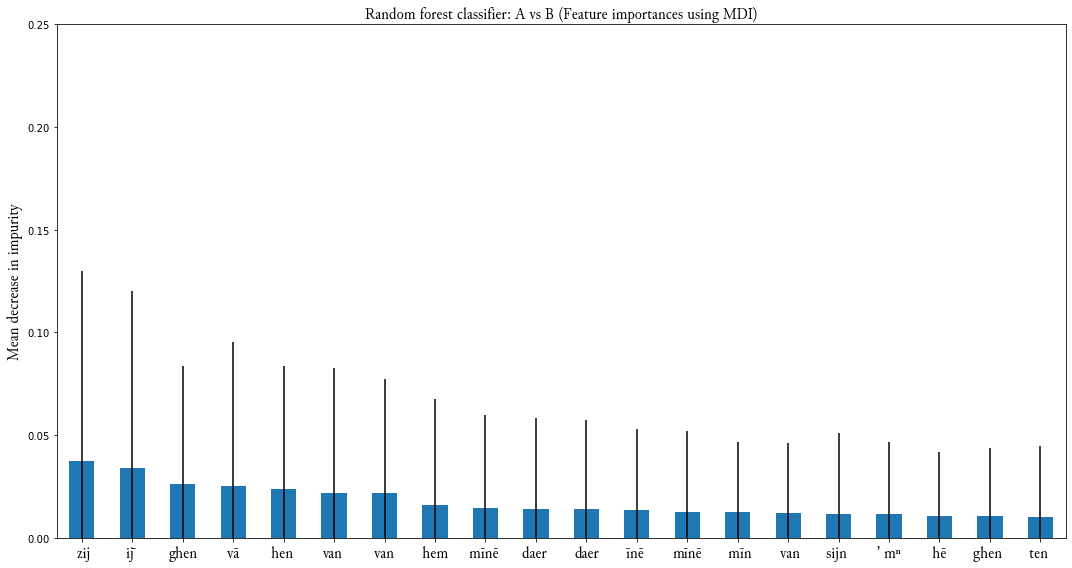

In [83]:
forest_importances = pd.Series(importances, index=names)

font = {'family': 'Junicode',
        'size': 15,
        }

fig, ax = plt.subplots(figsize=(15, 8))
forest_importances.plot.bar(yerr=std, ax=ax, rot=0)
ax.set_title("Random forest classifier: A vs B (Feature importances using MDI)", fontdict=font)
ax.set_ylabel("Mean decrease in impurity", fontdict=font)
ax.set_xticklabels(names, fontdict=font)
#ax.set_yticklabels(importances, fontdict=font)
ax.set_ylim((0, .25))
fig.tight_layout()
plt.savefig('gfx/features.pdf', transparent=False)

## Bootstrap on slices

In [84]:
num_boot_features = int(.5 * num_features)
num_bootstraps = 500 # default: 500

In [85]:
distances = []

for idx in tqdm(range(len(A_))):
    d = []
    for _ in range(num_bootstraps):
        rnd_idxs = np.random.choice(range(num_features), size=num_boot_features, replace=False)
        d.append(distance.cosine(A_[idx, rnd_idxs], B_[idx, rnd_idxs]))
    distances.append((idx + 1,
                      np.quantile(d, 0.05),
                      np.quantile(d, 0.50),
                      np.quantile(d, 0.95)
                     ))

100%|██████████| 250/250 [00:20<00:00, 12.08it/s]


In [86]:
df = pd.DataFrame(distances, columns=('position', 'q05', 'q50', 'q95'))
df

,position,q05,q50,q95
0,1,0.109121,0.138284,0.173282
1,2,0.075705,0.096939,0.129164
2,3,0.065663,0.084020,0.108778
3,4,0.077594,0.097954,0.124979
4,5,0.061860,0.080782,0.103147
...,...,...,...,...
245,246,0.092453,0.115848,0.142415
246,247,0.111337,0.147099,0.193741
247,248,0.124928,0.150741,0.190675
248,249,0.170335,0.224184,0.293283


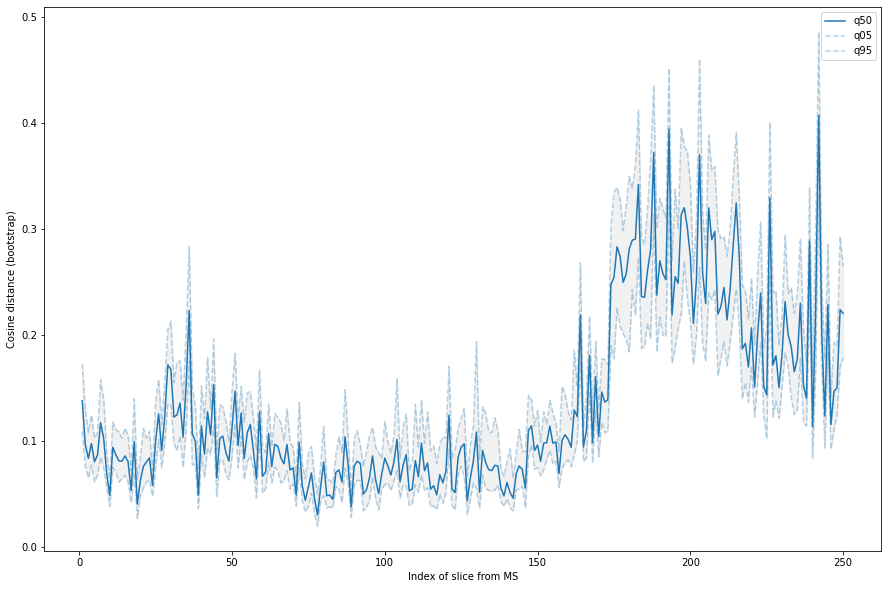

In [87]:
ax = df.plot(x='position', y='q50', figsize=(15,10), color='C0')
df.plot(x='position', y='q05', ax=ax, color='C0', ls='--', alpha=0.3)
df.plot(x='position', y='q95', ax=ax, color='C0', ls='--', alpha=0.3)
ax.fill_between(df['position'], df['q05'], df['q95'], color='lightgrey', alpha=0.3);
ax.set_ylabel('Cosine distance (bootstrap)');
ax.set_xlabel('Index of slice from MS');
plt.legend();
plt.savefig('gfx/distance_B_C.pdf', transparent=False)

In [88]:
d = np.polyfit(df['position'], df['q50'], 1)
f = np.poly1d(d)
df['pred'] = f(df['position'])

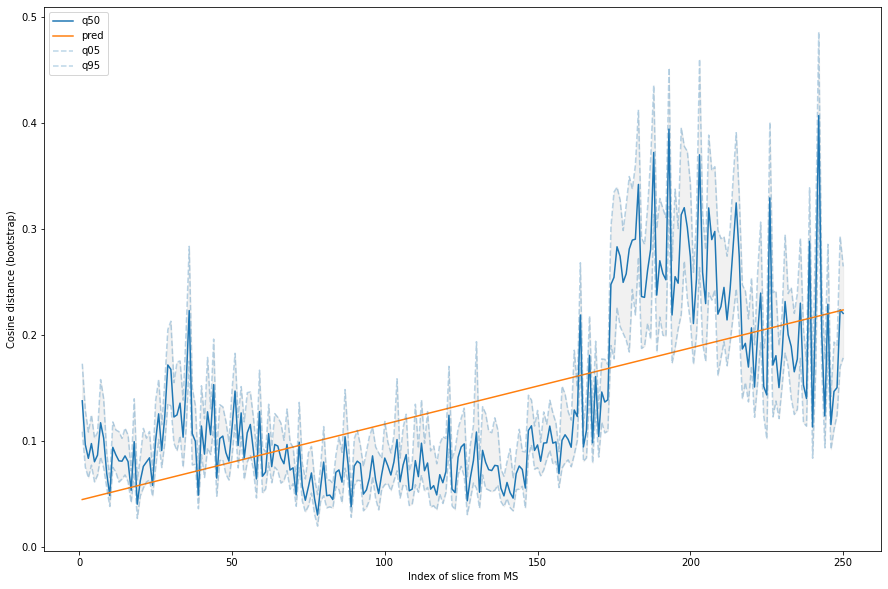

In [89]:
ax = df.plot(x='position', y='q50', figsize=(15,10), color='C0')
df.plot(x='position', y='pred', ax=ax, figsize=(15,10), color='C1')
df.plot(x='position', y='q05', ax=ax, color='C0', ls='--', alpha=0.3)
df.plot(x='position', y='q95', ax=ax, color='C0', ls='--', alpha=0.3)
ax.fill_between(df['position'], df['q05'], df['q95'], color='lightgrey', alpha=0.3);
ax.set_ylabel('Cosine distance (bootstrap)');
ax.set_xlabel('Index of slice from MS');
plt.legend();
plt.savefig('gfx/distance_regression.pdf', transparent=False)

In [90]:
for idx, a in enumerate(A):
    if 'HEt was in ene sōdage' in a:
        start_visions = idx
    if 'AY al es nu die winter cout' in a:
        start_songs = idx
    if 'eens beide bliuen Ja' in a:
        start_scribe2 = idx
        print(start_scribe2)
    if 'DJt nuwe iaer es ons begōnē' in a:
        start_scribe3 = idx
    if 'GOd si mꝫ v van mier groetene' in a:
        start_poems = idx
        print(start_poems)

24
217


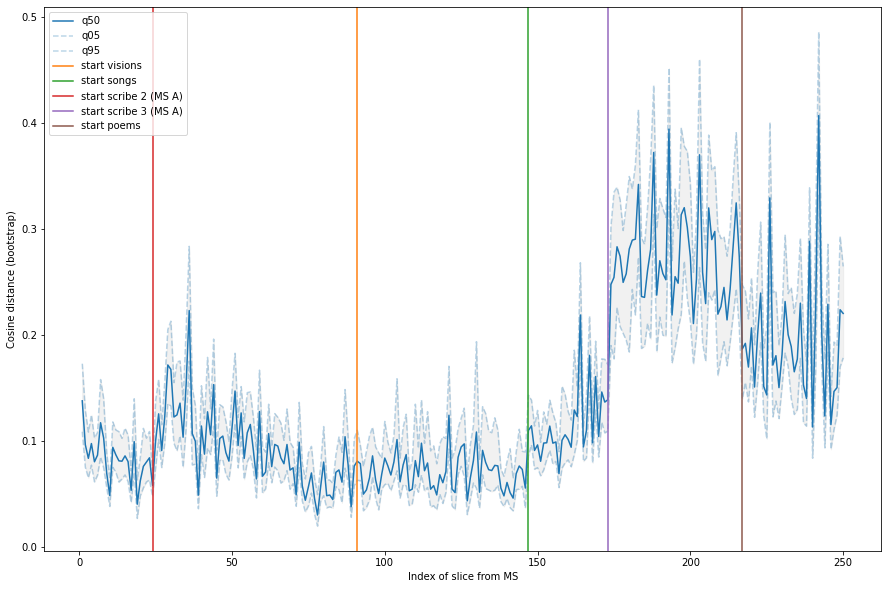

In [91]:
ax = df.plot(x='position', y='q50', figsize=(15,10), color='C0')
df.plot(x='position', y='q05', ax=ax, color='C0', ls='--', alpha=0.3)
df.plot(x='position', y='q95', ax=ax, color='C0', ls='--', alpha=0.3)
ax.fill_between(df['position'], df['q05'], df['q95'], color='lightgrey', alpha=0.3);
ax.set_ylabel('Cosine distance (bootstrap)');
ax.set_xlabel('Index of slice from MS');
plt.axvline(start_visions, color='C1', label='start visions')
plt.axvline(start_songs, color='C2', label='start songs')
plt.axvline(start_scribe2, color='C3', label='start scribe 2 (MS A)')
plt.axvline(start_scribe3, color='C4', label='start scribe 3 (MS A)')
plt.axvline(start_poems, color='C5', label='start poems')

plt.legend();
plt.savefig('gfx/distance_bars.pdf', transparent=False)

----------------------